In [1]:
import pandas as pd
import seaborn as sns
import math
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
print(df.shape)
print(df.columns)

(1460, 81)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

# Dropping columns with low variation in values

In [3]:
#drop columns with more than 85% density of 1 value

lowvarlst = []
for i in range(len(df.columns)):
    if df[df.columns[i]].value_counts().iloc[0]/len(df) > 0.85:
        print(df.columns[i])
        print(df[df.columns[i]].value_counts().iloc[0])
        print(df[df.columns[i]].value_counts().iloc[0]/len(df))
        print('-'*50)
        lowvarlst.append(df.columns[i])
        
print(len(lowvarlst))
df = df.drop(lowvarlst, axis=1)

Street
1454
0.9958904109589041
--------------------------------------------------
LandContour
1311
0.897945205479452
--------------------------------------------------
Utilities
1459
0.9993150684931507
--------------------------------------------------
LandSlope
1382
0.9465753424657535
--------------------------------------------------
Condition1
1260
0.863013698630137
--------------------------------------------------
Condition2
1445
0.9897260273972602
--------------------------------------------------
RoofMatl
1434
0.9821917808219178
--------------------------------------------------
ExterCond
1282
0.8780821917808219
--------------------------------------------------
BsmtCond
1311
0.897945205479452
--------------------------------------------------
BsmtFinType2
1256
0.8602739726027397
--------------------------------------------------
BsmtFinSF2
1293
0.8856164383561644
--------------------------------------------------
Heating
1428
0.9780821917808219
---------------------------------

# Dropping columns with too much missing data

In [4]:
pd.set_option('display.max_rows', 100)

print('Features with the most missing values:')

print('\n')

print(df.isna().sum().sort_values(ascending=False).head(10))

#Will drop the first 3
df = df.drop(['PoolQC', 'MiscFeature','Alley'], axis=1)

print('\n')

print(df.Fence.value_counts())
#Mostly missing and dispersed otherwise, will drop this

df = df.drop(['Fence'], axis=1)

Features with the most missing values:


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageFinish      81
GarageYrBlt       81
BsmtExposure      38
dtype: int64


MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64


----------------------------------Fireplace Quality----------------------------------

Text(0.5, 1.0, 'Average Sale Price by Fireplace Quality')

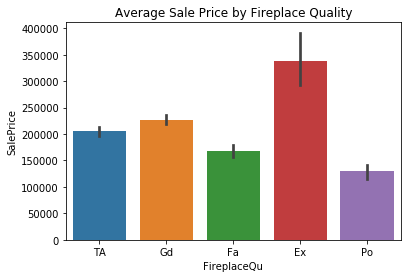

In [5]:
sns.barplot(x="FireplaceQu", y="SalePrice", data=df).set_title('Average Sale Price by Fireplace Quality')

0.5259323551065548


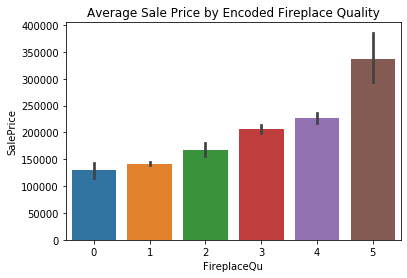

In [6]:
#Imputing empty fireplace values
for i in range(df.shape[0]):
    if df.FireplaceQu.isna()[i]:
        df.FireplaceQu[i] = 'None'     
        
#Label encoding for fireplaces. Might adjust "Excellent" label further upward later on
firecol = [0 if i=='Po' else 1 if i=='None' else 2 if i=='Fa' else 3 if i=='TA' else 4 if i=='Gd' else 5 for i in df.FireplaceQu]
df.FireplaceQu = firecol

sns.barplot(x="FireplaceQu", y="SalePrice", data=df).set_title('Average Sale Price by Encoded Fireplace Quality')

print(df.corr()['SalePrice']['FireplaceQu'])

------------------------------------Lot Frontage------------------------------------

259


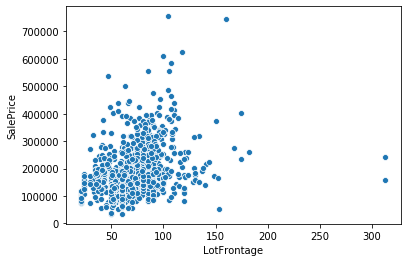

In [7]:
print(df.isna().sum()['LotFrontage'])
sns.scatterplot(x="LotFrontage", y='SalePrice', data=df)
#Imputation won't be too accurate, so will remove

In [8]:
df = df.drop(['LotFrontage'], axis=1)

--------------------------------Garage Type--------------------------------

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64


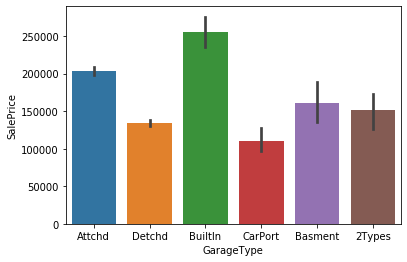

In [9]:
print(df.GarageType.value_counts())
sns.barplot(x="GarageType", y="SalePrice", data=df)

#I will isolate non-attached/detached/builtin and dummify

df.GarageType = ['GarageOther' if (i!='Attchd' and i!='Detchd' and i!='BuiltIn') else i for i in df.GarageType]

dfgarage = pd.get_dummies(df.GarageType)
dfgarage = dfgarage.drop(['GarageOther'], axis=1)
df = df.drop(['GarageType'], axis=1)
df = df.join(dfgarage)
df = df.rename(columns={"Attchd": "GarageAttchd", "Detchd": "GarageDetchd", "BuiltIn": "GarageBuiltIn"})

----------------------------------------GarageFinish----------------------------------------

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64


81


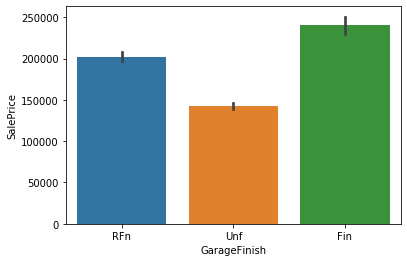

In [10]:
print(df.GarageFinish.value_counts())
print('\n')
print(df.isna().sum()['GarageFinish'])

sns.barplot(x="GarageFinish", y="SalePrice", data=df)

for i in range(df.shape[0]):
    if df.GarageFinish.isna()[i]:
        df.GarageFinish[i] = 'None'
        
df.GarageFinish = [0 if i=='None' else 1 if i=='Unf' else 2 if i=='RFn' else 3 for i in df.GarageFinish]

----------------------------------------Garage Year Built----------------------------------------

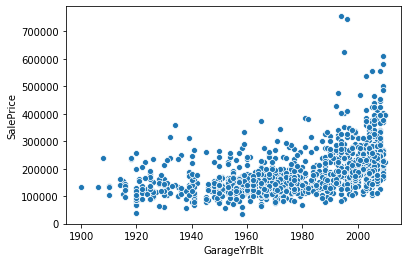

In [11]:
pd.set_option('display.max_rows', 100)
df.isna().sum().sort_values(ascending=False).head(15)['GarageYrBlt']

sns.scatterplot(x="GarageYrBlt", y='SalePrice', data=df)
#imputation issues, inevitable multicolinearity. I will drop this

df = df.drop(['GarageYrBlt'], axis=1)

----------------------------------------MasVnrType----------------------------------------

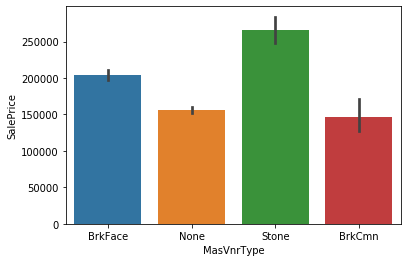

In [12]:
pd.set_option('display.max_rows', 100)

sns.barplot(x='MasVnrType',y='SalePrice',data=df)

#KNN for 8 missing values against SalesPrice

srs = df.MasVnrType.isna()
missing = srs[srs].index

missingdf = df.iloc[[i for i in missing],].copy()
notmissingdf = df.iloc[[i for i in range(len(df)) if i not in missing],].copy()

clf = KNeighborsClassifier(int(math.sqrt(len(df))), weights='distance')
trained_model = clf.fit(notmissingdf[['SalePrice']], notmissingdf[['MasVnrType']])

imputed_values = trained_model.predict(missingdf[['SalePrice']])

missingdf.MasVnrType = list(imputed_values)

df = notmissingdf.append(missingdf)
df = df.sort_values(by='Id')

----------------------------------------MasVnrArea----------------------------------------

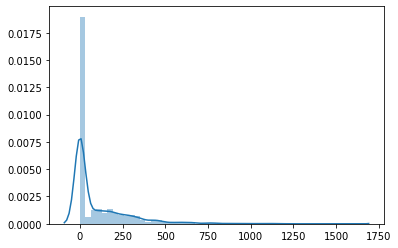

In [13]:
import matplotlib.pyplot as plt
vnrlst = [df.MasVnrArea[i] for i in range(len(df.MasVnrArea)) if df.MasVnrArea.isna()[i]==False]
sns.distplot(vnrlst)

len(df[df['MasVnrArea']==0]) / len(df)
#59% of the MasVnrArea data is 0.
#I will create a binary column of MasVnrArea>0

df.MasVnrArea = [1 if df.MasVnrArea[i] > 0 else 0 for i in range(len(df))]

----------------------------------------BsmtQual----------------------------------------

37


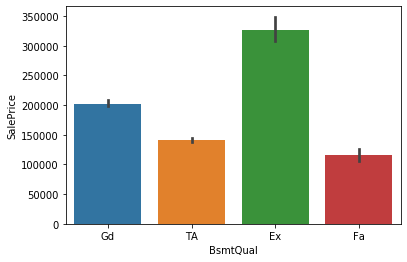

In [14]:
pd.set_option('display.max_rows', 100)
print(df.isna().sum().sort_values(ascending=False)['BsmtQual'])

sns.barplot(x='BsmtQual',y='SalePrice',data=df)

#Will impute with KNN

srs = df.BsmtQual.isna()
missing = srs[srs].index

missingdf = df.iloc[[i for i in missing],].copy()
notmissingdf = df.iloc[[i for i in range(len(df)) if i not in missing],].copy()

clf = KNeighborsClassifier(int(math.sqrt(len(df))), weights='distance')
trained_model = clf.fit(notmissingdf[['SalePrice']], notmissingdf[['BsmtQual']])

imputed_values = trained_model.predict(missingdf[['SalePrice']])

missingdf.BsmtQual = list(imputed_values)

df = notmissingdf.append(missingdf)
df = df.sort_values(by='Id')

----------------------------------------BsmtExposure----------------------------------------

38


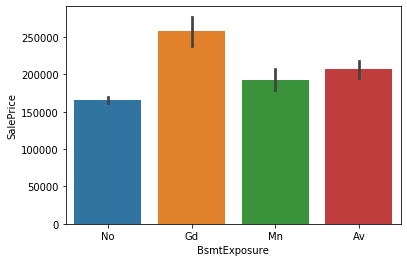

In [15]:
pd.set_option('display.max_rows', 100)
print(df.isna().sum().sort_values(ascending=False)['BsmtExposure'])

sns.barplot(x='BsmtExposure',y='SalePrice',data=df)

#Imputing with KNN

srs = df.BsmtExposure.isna()
missing = srs[srs].index

missingdf = df.iloc[[i for i in missing],].copy()
notmissingdf = df.iloc[[i for i in range(len(df)) if i not in missing],].copy()

clf = KNeighborsClassifier(int(math.sqrt(len(df))), weights='distance')
trained_model = clf.fit(notmissingdf[['SalePrice']], notmissingdf[['BsmtExposure']])

imputed_values = trained_model.predict(missingdf[['SalePrice']])

missingdf.BsmtExposure = list(imputed_values)

df = notmissingdf.append(missingdf)
df = df.sort_values(by='Id')

----------------------------------------BsmtFinType1----------------------------------------

37


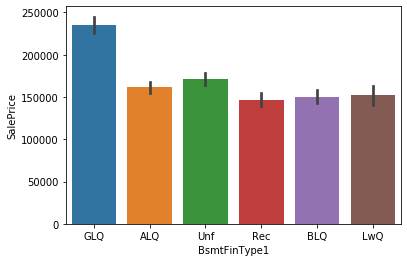

In [16]:
pd.set_option('display.max_rows', 100)
print(df.isna().sum().sort_values(ascending=False)['BsmtFinType1'])

sns.barplot(x='BsmtFinType1',y='SalePrice',data=df)

srs = df.BsmtFinType1.isna()
missing = srs[srs].index

missingdf = df.iloc[[i for i in missing],].copy()
notmissingdf = df.iloc[[i for i in range(len(df)) if i not in missing],].copy()

clf = KNeighborsClassifier(int(math.sqrt(len(df))), weights='distance')
trained_model = clf.fit(notmissingdf[['SalePrice']], notmissingdf[['BsmtFinType1']])

imputed_values = trained_model.predict(missingdf[['SalePrice']])

missingdf.BsmtFinType1 = list(imputed_values)

df = notmissingdf.append(missingdf)
df = df.sort_values(by='Id')

# Further investigating how to treat categorical variables

In [17]:
pd.set_option('display.max_columns', 999)
df.head()

,Id,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SaleCondition,SalePrice,GarageAttchd,GarageBuiltIn,GarageDetchd
0,1,60,RL,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,1,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,8,0,1,2,2,548,0,61,2,2008,Normal,208500,1,0,0
1,2,20,RL,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,6,1,3,2,2,460,298,0,5,2007,Normal,181500,1,0,0
2,3,60,RL,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,1,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,920,866,1786,1,2,1,3,Gd,6,1,3,2,2,608,0,42,9,2008,Normal,223500,1,0,0
3,4,70,RL,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,961,756,1717,1,1,0,3,Gd,7,1,4,1,3,642,0,35,2,2006,Abnorml,140000,0,0,1
4,5,60,RL,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,1,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,1145,1053,2198,1,2,1,4,Gd,9,1,3,2,3,836,192,84,12,2008,Normal,250000,1,0,0


--------------------------------------------------SaleCondition--------------------------------------------------

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64


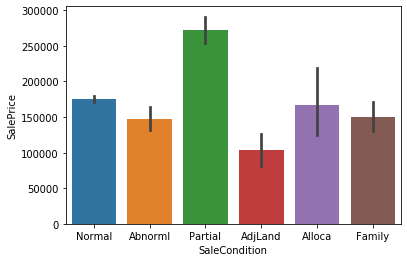

In [18]:
sns.barplot(x='SaleCondition',y='SalePrice',data=df)

print(df.SaleCondition.value_counts())

#Normal, the vast majority, is about average, and the others are scattered. Dropping this.

df = df.drop(['SaleCondition'], axis=1)

--------------------------------------------------MSZoning--------------------------------------------------

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


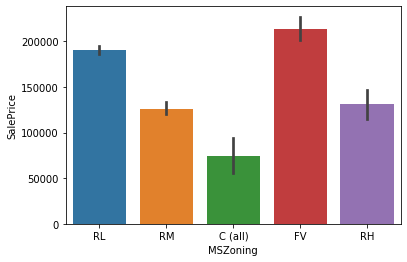

In [19]:
print(df.MSZoning.value_counts())

sns.barplot(x='MSZoning',y='SalePrice',data=df)

#Dropping this
df = df.drop(['MSZoning'], axis=1)

--------------------------------------------------LotShape--------------------------------------------------

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


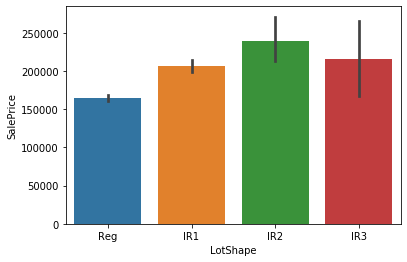

In [20]:
sns.barplot(x='LotShape',y='SalePrice',data=df)

print(df.LotShape.value_counts())

#Will combine the irregular lots and then dummify

df['RegularLotShape'] = [1 if df.LotShape[i]=='Reg' else 0 for i in range(len(df))]

df = df.drop(['LotShape'], axis=1)

--------------------------------------------------LotConfig--------------------------------------------------

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


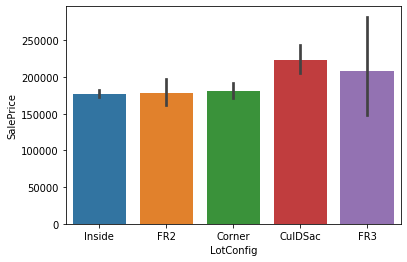

In [21]:
print(df.LotConfig.value_counts())

sns.barplot(x='LotConfig',y='SalePrice',data=df)

#Not enough variation here, dropping

df = df.drop(['LotConfig'], axis=1)

--------------------------------------------------Neighborhood--------------------------------------------------

In [22]:
df.Neighborhood.value_counts()

#too much variation, not worth keeping

df = df.drop(['Neighborhood'], axis=1)

--------------------------------------------------BldgType--------------------------------------------------

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64


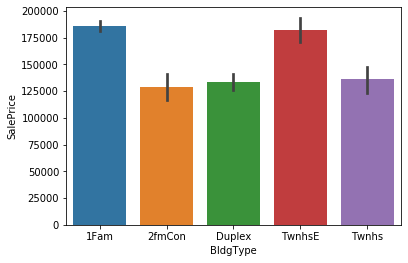

In [23]:
print(df.BldgType.value_counts())

sns.barplot(x='BldgType',y='SalePrice',data=df)

#A little too concentrated and not enough variation, dropping

df = df.drop(['BldgType'], axis=1)

--------------------------------------------------HouseStyle--------------------------------------------------

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64


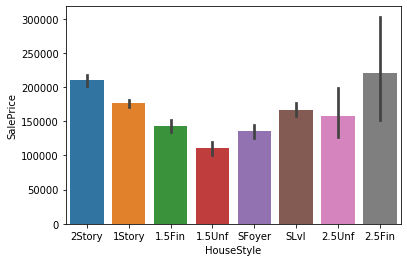

In [24]:
print(df.HouseStyle.value_counts())

sns.barplot(x='HouseStyle',y='SalePrice',data=df)

#this is a mess and captured in other variables. Removing
df = df.drop(['HouseStyle'], axis=1)

--------------------------------------------------RoofStyle--------------------------------------------------

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64


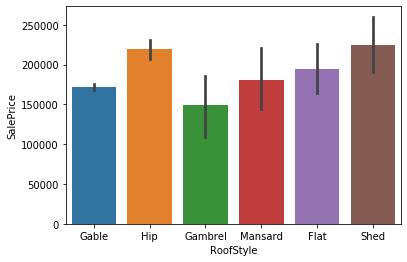

In [25]:
print(df.RoofStyle.value_counts())

sns.barplot(x='RoofStyle',y='SalePrice',data=df)

#Will dummify Gable/Hip/Other
roofdums = pd.get_dummies(df.RoofStyle)[['Hip','Gable']]
roofdums = roofdums.rename(columns={"Hip": "RoofHip", "Gable": "RoofGable"})
df = df.drop(['RoofStyle'], axis=1)
df = df.join(roofdums)

--------------------------------------------------Exterior1st--------------------------------------------------

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64


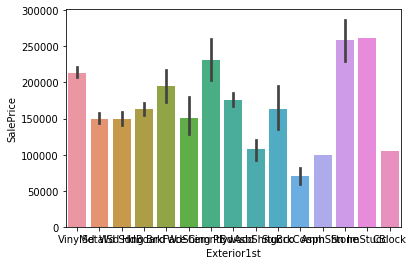

In [26]:
print(df.Exterior1st.value_counts())

sns.barplot(x='Exterior1st',y='SalePrice',data=df)

#The high volume ones don't have ultra-distinct SalePrices, dropping

df = df.drop(['Exterior1st'], axis=1)

--------------------------------------------------Exterior2nd--------------------------------------------------

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64


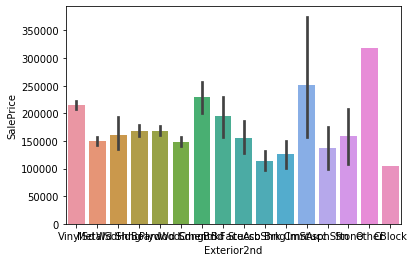

In [27]:
print(df.Exterior2nd.value_counts())

sns.barplot(x='Exterior2nd',y='SalePrice',data=df)

#same as above

df = df.drop(['Exterior2nd'], axis=1)

--------------------------------------------------MasVnrType--------------------------------------------------

None       868
BrkFace    448
Stone      129
BrkCmn      15
Name: MasVnrType, dtype: int64


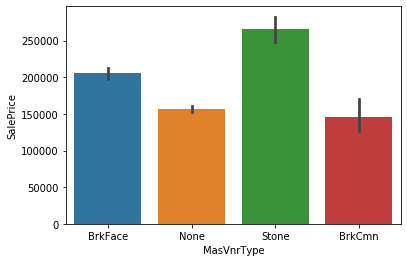

In [28]:
print(df.MasVnrType.value_counts())

sns.barplot(x='MasVnrType',y='SalePrice',data=df)

#Will dummify BrkFace, Stone, or other

vnrdums = pd.get_dummies(df.MasVnrType)[['BrkFace','Stone']]
vnrdums = vnrdums.rename(columns={"BrkFace": "MasVnrBrkFace", "Stone": "MasVnrStone"})
df = df.drop(['MasVnrType'], axis=1)
df = df.join(vnrdums)

--------------------------------------------------KitchenQual--------------------------------------------------

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64


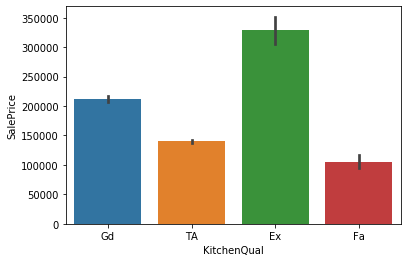

In [29]:
print(df.KitchenQual.value_counts())

sns.barplot(x='KitchenQual',y='SalePrice',data=df)

#Label Encoding

df.KitchenQual = [0 if df.KitchenQual[i]=='Fa' else 1 if df.KitchenQual[i]=='TA' else 2 if df.KitchenQual[i]=='Gd' else 3 for i in range(len(df))]

--------------------------------------------------ExterQual--------------------------------------------------

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64


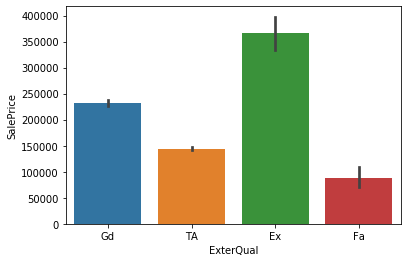

In [30]:
print(df.ExterQual.value_counts())

sns.barplot(x='ExterQual',y='SalePrice',data=df)

#label Encoding

df.ExterQual = [0 if df.ExterQual[i]=='Fa' else 1 if df.ExterQual[i]=='TA' else 2 if df.ExterQual[i]=='Gd' else 3 for i in range(len(df))]

--------------------------------------------------Foundation--------------------------------------------------

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64


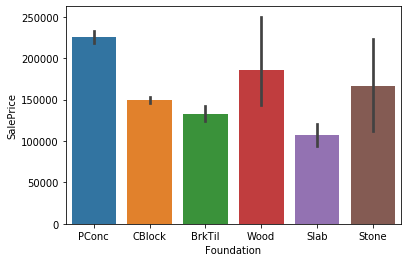

In [31]:
print(df.Foundation.value_counts())

sns.barplot(x='Foundation',y='SalePrice',data=df)

#Dummifying PConc, CBlock, Other

foundationdums = pd.get_dummies(df.Foundation)[['PConc','CBlock']]
foundationdums = foundationdums.rename(columns={"PConc": "FoundationPConc", "CBlock": "FoundationCBlock"})
df = df.drop(['Foundation'], axis=1)
df = df.join(foundationdums)

--------------------------------------------------BsmtQual--------------------------------------------------

TA    680
Gd    623
Ex    121
Fa     36
Name: BsmtQual, dtype: int64


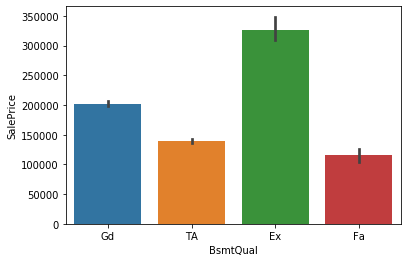

In [32]:
print(df.BsmtQual.value_counts())

sns.barplot(x='BsmtQual',y='SalePrice',data=df)

#Label Encoding

df.BsmtQual = [0 if df.BsmtQual[i]=='Fa' else 1 if df.BsmtQual[i]=='TA' else 2 if df.BsmtQual[i]=='Gd' else 3 for i in range(len(df))]

--------------------------------------------------BsmtExposure--------------------------------------------------

No    987
Av    223
Gd    135
Mn    115
Name: BsmtExposure, dtype: int64


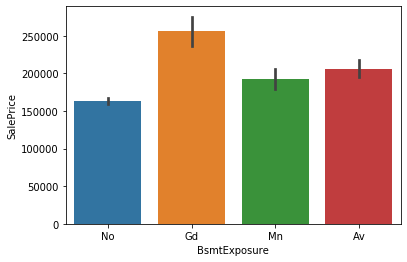

In [33]:
print(df.BsmtExposure.value_counts())

sns.barplot(x='BsmtExposure',y='SalePrice',data=df)

#Label Encoding

df.BsmtExposure = [0 if df.BsmtExposure[i]=='No' else 1 if df.BsmtExposure[i]=='Mn' else 2 if df.BsmtExposure[i]=='Av' else 3 for i in range(len(df))]

--------------------------------------------------BsmtFinType1--------------------------------------------------

Unf    454
GLQ    419
ALQ    225
BLQ    153
Rec    134
LwQ     75
Name: BsmtFinType1, dtype: int64


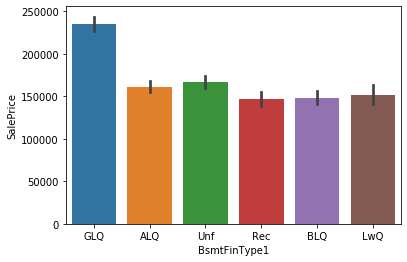

In [34]:
print(df.BsmtFinType1.value_counts())

sns.barplot(x='BsmtFinType1',y='SalePrice',data=df)

#Dummifying GLQ and other

finishdums = pd.get_dummies(df.BsmtFinType1)[['GLQ']]
finishdums = finishdums.rename(columns={"GLQ": "BsmtFinGLQ"})
df = df.drop(['BsmtFinType1'], axis=1)
df = df.join(finishdums)

--------------------------------------------------HeatingQC--------------------------------------------------

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64


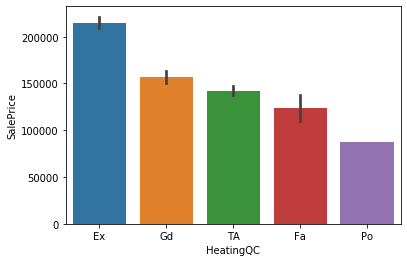

In [35]:
print(df.HeatingQC.value_counts())

sns.barplot(x='HeatingQC',y='SalePrice',data=df)

#Label Encoding

df.HeatingQC = [0 if df.HeatingQC[i]=='Po' else 1 if df.HeatingQC[i]=='Fa' else 2 if df.HeatingQC[i]=='TA' else 3 if df.HeatingQC[i]=='Gd' else 4 for i in range(len(df))]

# Removing non-correlated variables

In [36]:
df.corr()['SalePrice'].sort_values()

GarageDetchd       -0.354141
FoundationCBlock   -0.343263
RegularLotShape    -0.267672
RoofGable          -0.224744
MSSubClass         -0.084284
OverallCond        -0.077856
YrSold             -0.028923
Id                 -0.021917
MoSold              0.046432
BedroomAbvGr        0.168213
MasVnrBrkFace       0.204201
BsmtUnfSF           0.214479
BsmtFullBath        0.227122
GarageBuiltIn       0.235449
RoofHip             0.235897
LotArea             0.263843
HalfBath            0.284108
OpenPorchSF         0.315856
2ndFlrSF            0.319334
WoodDeckSF          0.324413
MasVnrStone         0.330076
GarageAttchd        0.335961
BsmtExposure        0.358455
MasVnrArea          0.360769
BsmtFinSF1          0.386420
HeatingQC           0.427649
BsmtFinGLQ          0.432887
Fireplaces          0.466929
FoundationPConc     0.497734
YearRemodAdd        0.507101
YearBuilt           0.522897
FireplaceQu         0.525932
TotRmsAbvGrd        0.533723
GarageFinish        0.549247
FullBath      

--------------------------------------------------MSSubClass--------------------------------------------------

-0.08428413512659523


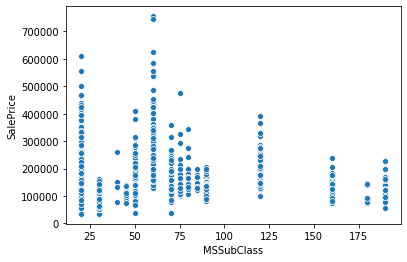

In [37]:
sns.scatterplot(x='MSSubClass',y='SalePrice',data=df)
print(df.corr()['SalePrice']['MSSubClass'])
df = df.drop(['MSSubClass'], axis=1)

--------------------------------------------------OverallCond--------------------------------------------------

-0.0778558940486776


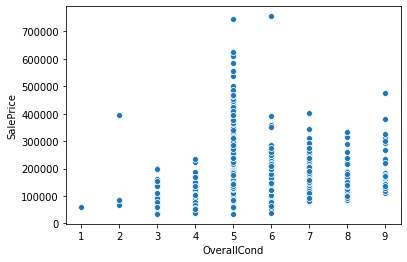

In [38]:
sns.scatterplot(x='OverallCond',y='SalePrice',data=df)
print(df.corr()['SalePrice']['OverallCond'])
df = df.drop(['OverallCond'], axis=1)

--------------------------------------------------BedroomAbvGr--------------------------------------------------

0.1682131543007415


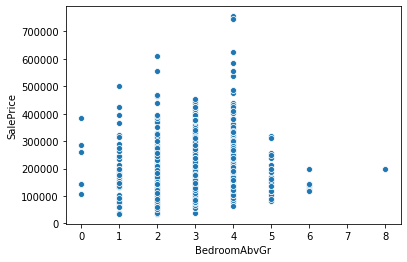

In [39]:
sns.scatterplot(x='BedroomAbvGr',y='SalePrice',data=df)
print(df.corr()['SalePrice']['BedroomAbvGr'])
df = df.drop(['BedroomAbvGr'], axis=1)

# Dropping random/extraneous variables

In [40]:
#Good to drop extraneous ID/Date columns, especially considering they showed low correlation

df = df.drop(['Id', 'YrSold', 'MoSold'], axis=1)

# Removing Outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f7377f0>,
      dtype=object)

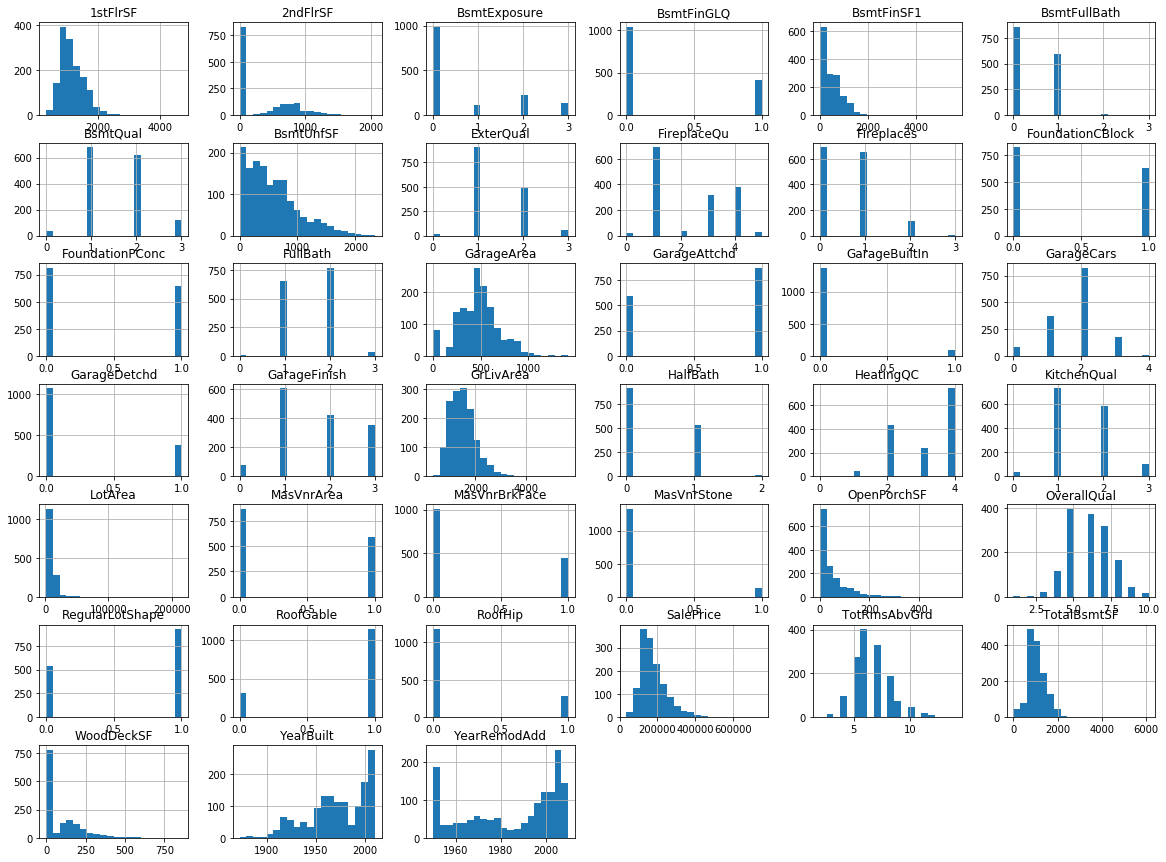

In [41]:
df.hist(bins=20, figsize=(20,15))

In [42]:
#A few variables are clunky with how many values are concentrated at 0, and the correlation with SalePrice is not too high anyway. I will remove.

vars_concentrated_at_zero = ['2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'LotArea', 'BsmtUnfSF', 'BsmtFinSF1']

df.corr()[vars_concentrated_at_zero].loc['SalePrice']

df = df.drop(vars_concentrated_at_zero, axis=1)

--------------------------------1stFlrSF--------------------------------

      1stFlrSF  SalePrice
1298      4692     160000
496       3228     430000
523       3138     184750
1024      2898     287000
1373      2633     466500
1044      2524     278000
529       2515     200624
691       2444     755000
1182      2411     745000
440       2402     555000


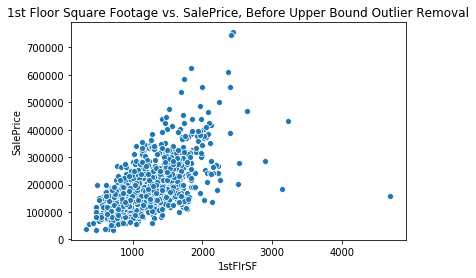

In [43]:
pd.set_option('display.max_rows', 10000)
sns.scatterplot(x='1stFlrSF',y='SalePrice',data=df).set_title('1st Floor Square Footage vs. SalePrice, Before Upper Bound Outlier Removal')
print(df.sort_values('1stFlrSF', ascending=False).head(10)[['1stFlrSF','SalePrice']])
#Will remove biggest 3 points and see how it fixes distribution
df = df.drop([1298,496,523,1024], axis=0)

Text(0.5, 1.0, '1st Floor Square Footage vs. SalePrice, After Upper Bound Outlier Removal')

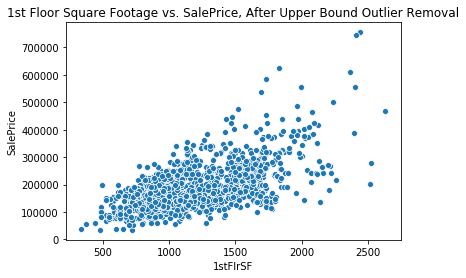

In [44]:
sns.scatterplot(x='1stFlrSF',y='SalePrice',data=df).set_title('1st Floor Square Footage vs. SalePrice, After Upper Bound Outlier Removal')

--------------------------------GrLivArea--------------------------------

In [45]:
df['GrLivArea'].sort_values(ascending=False)
#dropping largest 2
df = df.drop([1182,691], axis=0)

--------------------------------OverallQual--------------------------------

In [46]:
print(df.corr()['SalePrice']['OverallQual'])
df.corr()['OverallQual'].sort_values(ascending = False).head(15)
#OverallQual is a good variable because it's highly correlated with SalesPrice, but also a bad variable because it's correlated with everything else. 
#I will keep it and hope that a regularized regression is able to adjust it accordingly.

0.8009277260156535


OverallQual        1.000000
SalePrice          0.800928
ExterQual          0.721456
KitchenQual        0.667586
BsmtQual           0.658111
GarageCars         0.598977
GrLivArea          0.582268
YearBuilt          0.571762
FoundationPConc    0.567657
GarageArea         0.554617
GarageFinish       0.552813
YearRemodAdd       0.551805
FullBath           0.542635
TotalBsmtSF        0.532458
FireplaceQu        0.496485
Name: OverallQual, dtype: float64

--------------------------------SalePrice--------------------------------

In [47]:
print(df.SalePrice.sort_values(ascending=True).head(25))
#Removing abnormally small SalePrices
df = df.drop([495,916,968,533,30], axis=0)

495     34900
916     35311
968     37900
533     39300
30      40000
710     52000
1337    52500
1325    55000
705     55000
812     55993
1380    58500
410     60000
1100    60000
636     60000
375     61000
462     62383
1432    64500
874     66500
620     67000
398     67000
1279    68400
29      68500
1321    72500
264     73000
915     75000
Name: SalePrice, dtype: int64


--------------------------------1stFlrSF--------------------------------

      1stFlrSF  SalePrice
1373      2633     466500
1044      2524     278000
529       2515     200624
440       2402     555000
224       2392     386250
898       2364     611657
113       2259     217000
178       2234     501837
70        2223     244000
888       2217     268000
66        2207     180000
1205      2196     271900
175       2158     243000
1346      2156     262500
1223      2136     137900
1175      2129     285000
278       2121     415298
1381      2117     237500
654       2113     350000
1250      2110     244000
664       2097     423000
825       2084     385000
1243      2076     465000
1456      2073     210000
934       2069     242000


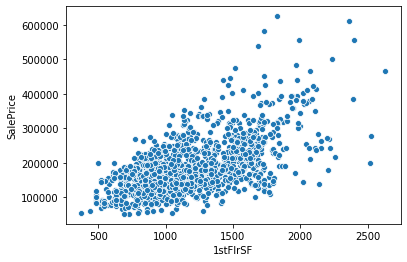

In [48]:
print(df[['1stFlrSF','SalePrice']].sort_values('1stFlrSF', ascending=False).head(25))
sns.scatterplot(x='1stFlrSF',y='SalePrice',data=df)
#Removing outliers
df = df.drop([1373,1044,629,113,66,1223,529], axis=0)

--------------------------------GarageArea--------------------------------

      GarageArea  SalePrice
581         1390     253293
1190        1356     168000
1061        1248      81000
825         1220     385000
178         1166     501837
664         1134     423000
1417        1069     340000
270         1053     266000
1228        1052     367294
1142        1052     424870
1087        1043     252000
317         1025     270000
803         1020     582933
1268        1014     381000
1184         995     186700
718          983     341000
224          968     386250
1350         968     200000
1241         954     248328
408          947     280000
1374         936     250000
1404         936     105000
1115         928     318000
268          924     120500
1161         924     224000


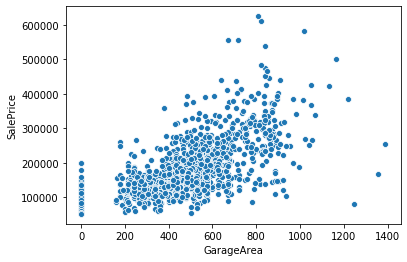

In [49]:
print(df[['GarageArea','SalePrice']].sort_values('GarageArea', ascending=False).head(25))
sns.scatterplot(x='GarageArea',y='SalePrice',data=df)
df = df.drop([581,1190,1061], axis=0)

--------------------------------GrLivArea--------------------------------

,GrLivArea,SalePrice
1169,3627,625000
185,3608,475000
1268,3447,381000
769,3279,538000
1353,3238,410000
118,3222,320000
608,3194,359100
798,3140,485000
324,2978,242000
58,2945,438780


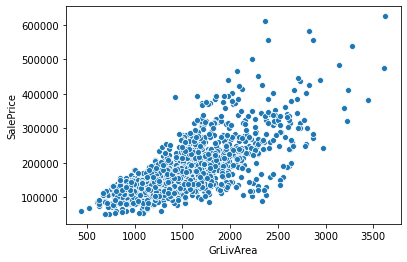

In [50]:
df = df.drop([304,197,1173,1031,1031,635], axis=0)
sns.scatterplot(x='GrLivArea',y='SalePrice',data=df)
df[['GrLivArea','SalePrice']].sort_values('GrLivArea', ascending=False).head(25)

--------------------------------TotRmsAbvGrd--------------------------------

1386    12
769     12
1230    12
803     12
897     12
1350    12
185     12
910     12
961     11
1440    11
566     11
745     11
898     11
1046    11
798     11
1416    11
809     11
1142    11
1268    11
875     11
11      11
118     11
324     11
527     11
1292    11
Name: TotRmsAbvGrd, dtype: int64


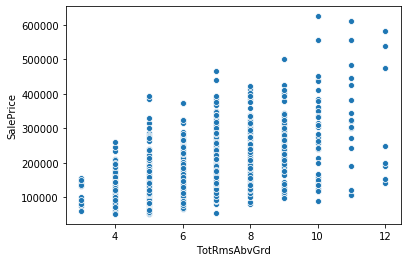

In [51]:
print(df.TotRmsAbvGrd.sort_values(ascending=False).head(25))
sns.scatterplot(x='TotRmsAbvGrd',y='SalePrice',data=df)
#No outliers

--------------------------------TotalBsmtSF--------------------------------

      TotalBsmtSF  SalePrice
332          3206     284000
440          3094     555000
224          2392     386250
898          2330     611657
70           2223     244000
888          2217     268000
178          2216     501837
1205         2158     271900
477          2153     380000
313          2136     375000
278          2121     415298
1250         2110     244000
654          2109     350000
825          2078     385000
664          2077     423000
1243         2076     465000
678          2046     372500
1353         2033     410000
515          2006     402861
1267         2002     378500
305          2000     305900
1046         1992     556581
1256         1986     301500
1359         1980     315000
473          1976     440000


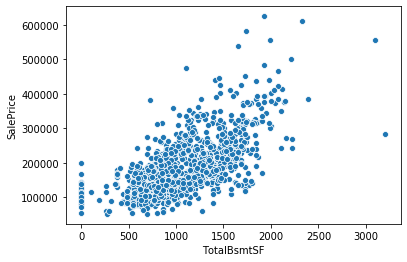

In [52]:
print(df[['TotalBsmtSF','SalePrice']].sort_values('TotalBsmtSF', ascending=False).head(25))
sns.scatterplot(x='TotalBsmtSF',y='SalePrice',data=df)
df = df.drop([332,440], axis=0)

# Transforming outcome variable

Text(0.5, 1.0, 'SalePrice Distribution, Pre-Transformation')

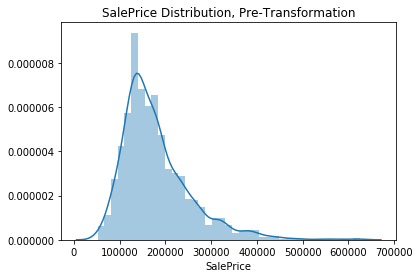

In [53]:
sns.distplot(df.SalePrice).set_title('SalePrice Distribution, Pre-Transformation')

Text(0.5, 1.0, 'SalePrice Distribution, Post-Transformation')

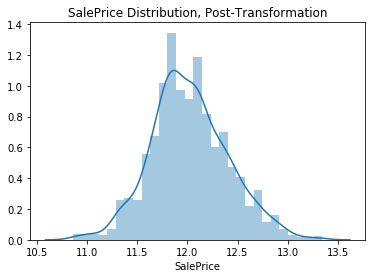

In [54]:
df.SalePrice = [math.log(i) for i in df.SalePrice]
sns.distplot(df.SalePrice).set_title('SalePrice Distribution, Post-Transformation')

# Pre-ML

In [55]:
# Manipulating testing data to match training data

testdf = pd.read_csv('test.csv')
dfstorage = df.copy()
df = testdf

df = df.drop(lowvarlst, axis=1)

df = df.drop(['PoolQC', 'MiscFeature','Alley', 'GarageYrBlt', 'Fence', 'LotFrontage', 'SaleCondition', 'MSZoning', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MSSubClass', 'OverallCond', 'BedroomAbvGr', 'Id', 'YrSold', 'MoSold', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'LotArea', 'BsmtUnfSF', 'BsmtFinSF1'], axis=1)

firecol = [0 if i=='Po' else 1 if i=='None' else 2 if i=='Fa' else 3 if i=='TA' else 4 if i=='Gd' else 5 for i in df.FireplaceQu]
df.FireplaceQu = firecol

df['GarageType'] = ['GarageOther' if (i!='Attchd' and i!='Detchd' and i!='BuiltIn') else i for i in df['GarageType']]
dfgarage = pd.get_dummies(df.GarageType)
dfgarage = dfgarage.drop(['GarageOther'], axis=1)
df = df.drop(['GarageType'], axis=1)
df = df.join(dfgarage)
df = df.rename(columns={"Attchd": "GarageAttchd", "Detchd": "GarageDetchd", "BuiltIn": "GarageBuiltIn"})

for i in range(df.shape[0]):
    if df.GarageFinish.isna()[i]:
        df.GarageFinish[i] = 'None'
df.GarageFinish = [0 if i=='None' else 1 if i=='Unf' else 2 if i=='RFn' else 3 for i in df.GarageFinish]

df.MasVnrArea = [1 if df.MasVnrArea[i] > 0 else 0 for i in range(len(df))]

df['RegularLotShape'] = [1 if i =='Reg' else 0 for i in df['LotShape']]
df = df.drop(['LotShape'], axis=1)

roofdums = pd.get_dummies(df.RoofStyle)[['Hip','Gable']]
roofdums = roofdums.rename(columns={"Hip": "RoofHip", "Gable": "RoofGable"})
df = df.drop(['RoofStyle'], axis=1)
df = df.join(roofdums)

vnrdums = pd.get_dummies(df.MasVnrType)[['BrkFace','Stone']]
vnrdums = vnrdums.rename(columns={"BrkFace": "MasVnrBrkFace", "Stone": "MasVnrStone"})
df = df.drop(['MasVnrType'], axis=1)
df = df.join(vnrdums)

df.KitchenQual = [0 if df.KitchenQual[i]=='Fa' else 1 if df.KitchenQual[i]=='TA' else 2 if df.KitchenQual[i]=='Gd' else 3 for i in range(len(df))]

df.ExterQual = [0 if df.ExterQual[i]=='Fa' else 1 if df.ExterQual[i]=='TA' else 2 if df.ExterQual[i]=='Gd' else 3 for i in range(len(df))]

foundationdums = pd.get_dummies(df.Foundation)[['PConc','CBlock']]
foundationdums = foundationdums.rename(columns={"PConc": "FoundationPConc", "CBlock": "FoundationCBlock"})
df = df.drop(['Foundation'], axis=1)
df = df.join(foundationdums)

df.BsmtQual = [0 if df.BsmtQual[i]=='Fa' else 1 if df.BsmtQual[i]=='TA' else 2 if df.BsmtQual[i]=='Gd' else 3 for i in range(len(df))]

df.BsmtExposure = [0 if df.BsmtExposure[i]=='No' else 1 if df.BsmtExposure[i]=='Mn' else 2 if df.BsmtExposure[i]=='Av' else 3 for i in range(len(df))]

finishdums = pd.get_dummies(df.BsmtFinType1)[['GLQ']]
finishdums = finishdums.rename(columns={"GLQ": "BsmtFinGLQ"})
df = df.drop(['BsmtFinType1'], axis=1)
df = df.join(finishdums)

df.HeatingQC = [0 if df.HeatingQC[i]=='Po' else 1 if df.HeatingQC[i]=='Fa' else 2 if df.HeatingQC[i]=='TA' else 3 if df.HeatingQC[i]=='Gd' else 4 for i in range(len(df))]

#Dealing with missing values in the test set

print(df.isna().sum().sort_values(ascending=False).head())

#Few missing values, so using mean imputation for simplicity:

for i in range(len(testdf)):
    if np.isnan(testdf.TotalBsmtSF[i]):
        df.TotalBsmtSF[i]=df.TotalBsmtSF.mean()
    if np.isnan(testdf.BsmtFullBath[i]):
        df.BsmtFullBath[i]=df.BsmtFullBath.mean()
    if np.isnan(df.GarageCars[i]):
        df.GarageCars[i]=df.GarageCars.mean()
    if np.isnan(df.GarageArea[i]):
        df.GarageArea[i]=df.GarageArea.mean()
        
testdf = df.copy()
df = dfstorage

BsmtFullBath    2
TotalBsmtSF     1
GarageCars      1
GarageArea      1
HeatingQC       0
dtype: int64


In [56]:
# Seperating target column

saleprice = df.SalePrice
df = df.drop(['SalePrice'], axis=1)

In [57]:
# Defining functions to fit model and output error

def split_test(X_train, y_train, X_test, y_test, model, show = True): #call what we got from the split
    model.fit(X_train, y_train) #fit the model
    train_accuracy = model.score(X_train, y_train) #how it performs on the data it was trained on
    test_accuracy  = model.score(X_test, y_test) #how it performs on data we held out
    if show: #we can change the argument to show=False if we don't want to print the errors
        print("The training accuracy is: %.5f" %train_accuracy)
        print("The test     accuracy is: %.5f" %test_accuracy)
    return [train_accuracy, test_accuracy]

def full_test(x, y, model, show = True): #call what we got from the split
    model.fit(x,y) #fit the model
    train_accuracy = model.score(x,y) #how it performs on the data it was trained on
    if show: #we can change the argument to show=False if we don't want to print the errors
        print("The training accuracy is: %.5f" %train_accuracy)
    return [train_accuracy]

# Multi-Linear Regression

In [58]:
# Fitting the models

X_train, X_test, y_train, y_test = train_test_split(df, saleprice, test_size=0.2, random_state=0)

split_lm = LinearRegression()
full_lm = LinearRegression()

print('SPLIT TEST:')
print(split_test(X_train, y_train, X_test, y_test, split_lm))
print('-'*50)
print('FULL TEST:')
print(full_test(df, saleprice, full_lm))

#Making predictions from split model and outputting to CSV:

preds = [math.e**i for i in split_lm.predict(testdf)]
Id = [i for i in range(1461,2920)]
testdict = {'Id': Id, 'SalePrice': preds}
finaldf = pd.DataFrame(data=testdict).set_index('Id')
finaldf.to_csv('splitMLR.csv')

#Making predictions from full model and outputting to CSV:

preds = [math.e**i for i in full_lm.predict(testdf)]
Id = [i for i in range(1461,2920)]
testdict = {'Id': Id, 'SalePrice': preds}
finaldf = pd.DataFrame(data=testdict).set_index('Id')
finaldf.to_csv('fullMLR.csv')

SPLIT TEST:
The training accuracy is: 0.89231
The test     accuracy is: 0.87756
[0.8923064372542873, 0.8775640224606419]
--------------------------------------------------
FULL TEST:
The training accuracy is: 0.88972
[0.8897215279681329]


# Lasso

SPLIT LASSO:
[0.8923064296219865, 0.892305673999885, 0.8922301221710814, 0.8893179333523156, 0.8110819445469856, 0.7735838339309611]
--------------------------------------------------
0.8110819445469856
0.8109645097590168


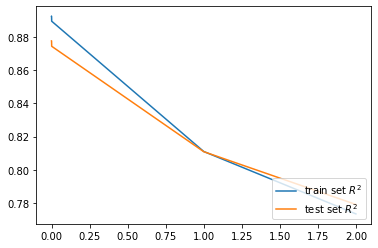

In [59]:
lasso = Lasso()

print('SPLIT LASSO:')

train_R2 = []
test_R2  = []
alphaRange = [1e-6,1e-5,1e-4,1e-3,1,2]
for alpha in alphaRange:
    lasso.set_params(alpha=alpha, normalize=False)  
    lasso.fit(X_train, y_train)
    train_R2.append(lasso.score(X_train, y_train))
    test_R2.append(lasso.score(X_test, y_test))
    
print(train_R2)

plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)

lasso.set_params(alpha=1, normalize=False)
lasso.fit(X_train, y_train)
print('-'*50)
print(lasso.score(X_train, y_train))
print(lasso.score(X_test, y_test))

#Making predictions and outputting to CSV:

preds = [math.e**i for i in lasso.predict(testdf)]
Id = [i for i in range(1461,2920)]
testdict = {'Id': Id, 'SalePrice': preds}
finaldf = pd.DataFrame(data=testdict).set_index('Id')
finaldf.to_csv('lasso.csv')

# Ridge

SPLIT RIDGE:
[0.8923064372542873, 0.8923064372542848, 0.8923064372540517, 0.8923064372307377, 0.8922871312487733, 0.8922416022729972]
--------------------------------------------------
0.8922871312487733
0.877495477318409


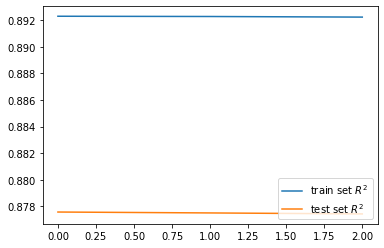

In [60]:
ridge = Ridge()

print('SPLIT RIDGE:')

train_R2 = []
test_R2  = []
alphaRange = [1e-6,1e-5,1e-4,1e-3,1,2]
for alpha in alphaRange:
    ridge.set_params(alpha=alpha, normalize=False)  
    ridge.fit(X_train, y_train)
    train_R2.append(ridge.score(X_train, y_train))
    test_R2.append(ridge.score(X_test, y_test))
    
print(train_R2)

plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)

ridge.set_params(alpha=1, normalize=False)
ridge.fit(X_train, y_train)
print('-'*50)
print(ridge.score(X_train, y_train))
print(ridge.score(X_test, y_test))

#Making predictions and outputting to CSV:

preds = [math.e**i for i in ridge.predict(testdf)]
Id = [i for i in range(1461,2920)]
testdict = {'Id': Id, 'SalePrice': preds}
finaldf = pd.DataFrame(data=testdict).set_index('Id')
finaldf.to_csv('ridge.csv')